In [75]:
import pandas as pd
import numpy as np
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [76]:
num_classes = 4
num_features = 2
RANDOM_SEED=42


In [77]:
X,Y = make_blobs(n_samples = 1000,
                 n_features = num_features,
                 centers=num_classes,
                 cluster_std=1.3,
                 random_state=RANDOM_SEED)


In [78]:
X_tensor = torch.from_numpy(X).type(torch.float)
Y_tensor = torch.from_numpy(Y).type(torch.long)

In [79]:
X_train,X_test, y_train, y_test = train_test_split(X_tensor,Y_tensor,test_size=0.2,
                                                   random_state=RANDOM_SEED)

In [80]:
X_train.shape

torch.Size([800, 2])

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

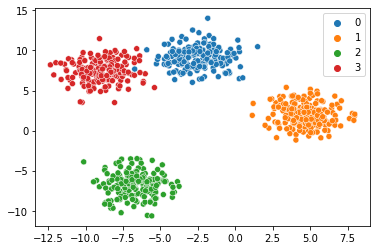

In [82]:
sns.scatterplot(x = X_train[:,0],y=X_train[:,1],hue=y_train, palette= sns.color_palette(n_colors=4))

In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [84]:
from torch import nn

In [85]:
class Multi_Classification(nn.Module):
  def __init__(self,input_feat,output_feat,hidden_units=8):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_feat, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_feat),
    )

  def forward(self,x):
    return self.layer_stack(x)


In [86]:
multi_class_model = Multi_Classification(input_feat =num_features,output_feat = num_classes).to(device)

In [87]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(multi_class_model.parameters(),lr =0.1)

In [88]:
def accuracy_fn(y_pred,y_true):
  correct = torch.eq(y_pred,y_true).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [89]:
torch.manual_seed(RANDOM_SEED)

epochs=100

X_train,X_test = X_train.to(device),X_test.to(device)
y_train,y_test = y_train.to(device),y_test.to(device)

for epoch in range(epochs):
  multi_class_model.train()

  y_logits = multi_class_model(X_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  
  loss = loss_fn(y_logits,y_train)
  accuracy = accuracy_fn(y_pred,y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  multi_class_model.eval()
  with torch.inference_mode():
    y_test_logits = multi_class_model(X_test)
    y_test_pred = torch.softmax(y_test_logits,dim=1).argmax(dim=1)
  
    test_loss = loss_fn(y_test_logits,y_test)
    test_accuracy = accuracy_fn(y_test_pred,y_test)
  if epoch % 10 == 0:
        print(f"Epoch: {epoch}| Loss: {loss:.5f}, Acc: {accuracy:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_accuracy:.2f}%")
       



Epoch: 0| Loss: 1.15586, Acc: 39.25% | Test Loss: 1.07202, Test Acc: 47.50%
Epoch: 10| Loss: 0.63416, Acc: 98.00% | Test Loss: 0.65060, Test Acc: 98.00%
Epoch: 20| Loss: 0.40911, Acc: 99.75% | Test Loss: 0.41370, Test Acc: 100.00%
Epoch: 30| Loss: 0.23080, Acc: 99.88% | Test Loss: 0.22282, Test Acc: 100.00%
Epoch: 40| Loss: 0.09259, Acc: 99.75% | Test Loss: 0.08440, Test Acc: 100.00%
Epoch: 50| Loss: 0.04996, Acc: 99.75% | Test Loss: 0.04427, Test Acc: 100.00%
Epoch: 60| Loss: 0.03534, Acc: 99.75% | Test Loss: 0.02996, Test Acc: 100.00%
Epoch: 70| Loss: 0.02813, Acc: 99.75% | Test Loss: 0.02279, Test Acc: 100.00%
Epoch: 80| Loss: 0.02400, Acc: 99.75% | Test Loss: 0.01872, Test Acc: 100.00%
Epoch: 90| Loss: 0.02132, Acc: 99.75% | Test Loss: 0.01604, Test Acc: 100.00%


In [90]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


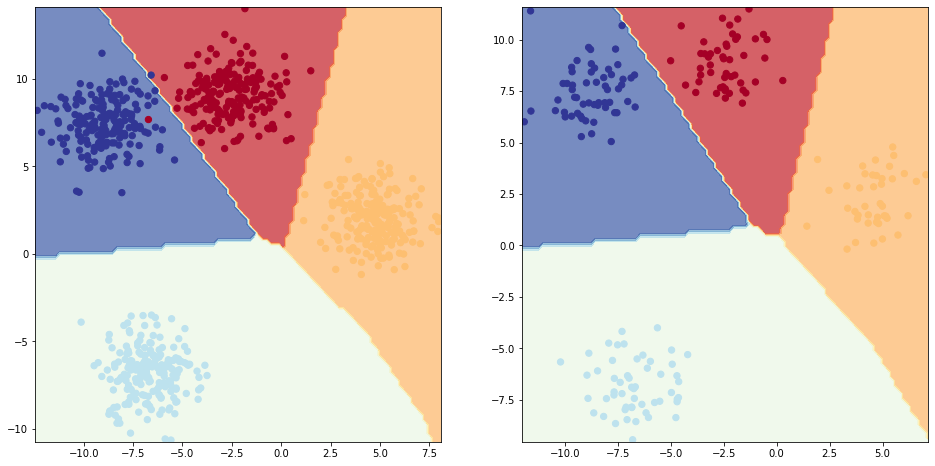

In [91]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_decision_boundary(multi_class_model,X_train,y_train)
plt.subplot(1,2,2)
plot_decision_boundary(multi_class_model,X_test,y_test)